# Load data

In [41]:
import pickle
from sklearn import preprocessing, decomposition
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
data_dict = pickle.load(open("../final_project_dataset.pkl", "r") )
features_list = ['poi', 'salary', 'deferral_payments', 'total_payments', 'loan_advances',
                 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value',
                 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive',
                 'restricted_stock', 'director_fees', 'to_messages', 
                 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 
                 'shared_receipt_with_poi']

In [7]:
%run ../../tools/feature_format

# Remove outliers

Two outliers has been detected in the dataset and are removed bellow.

In [8]:
print "Size of the dataset before outlier puring", len(data_dict)
data_dict.pop('TOTAL',0)
data_dict.pop('LOCKHART EUGENE E',0)
print "Size of the dataset after outlier puring",len(data_dict)

Size of the dataset before outlier puring 146
Size of the dataset after outlier puring 144


# Creation of new features

Two new features has been computed, the fraction of email a person receives that come from a POI and the fraction of emails a person send to a POI.

In [9]:
def computeFraction( poi_messages, all_messages ):
    """ given a number messages to/from POI (numerator) 
        and number of all messages to/from a person (denominator),
        return the fraction of messages to/from that person
        that are from/to a POI
   """
    fraction = 0.

    if all_messages == 'NaN':
        return fraction
    
    if poi_messages == 'NaN':
        poi_messages = 0
    
    fraction = float(poi_messages)/float(all_messages)

    return fraction

for name in data_dict:

    data_point = data_dict[name]

    from_poi_to_this_person = data_point["from_poi_to_this_person"]
    to_messages = data_point["to_messages"]
    fraction_from_poi = computeFraction(from_poi_to_this_person, to_messages)
    data_point["fraction_from_poi"] = fraction_from_poi

    from_this_person_to_poi = data_point["from_this_person_to_poi"]
    from_messages = data_point["from_messages"]
    fraction_to_poi = computeFraction(from_this_person_to_poi, from_messages)
    data_point["fraction_to_poi"] = fraction_to_poi

features_list.append('fraction_from_poi')
features_list.append('fraction_to_poi')

# Scaling features

All features has been scaled to be between 0 and 1.  The features needed to be scaled since they were on vastly different scaled, ranging from hundreds to millions of dollars.  Also, the feature scaling remove the negative values which are not accepted by some models.

In [10]:
### Store to my_dataset for easy export below.
my_dataset = data_dict

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

### scaling features
features = preprocessing.MinMaxScaler().fit_transform(features)


# Feature selection exploration

The initial step is to create some utilities functions that will be used as part of our accuracy study.

In [11]:
# Plot a graph of the accuracy versus the number of features
def plot(accuracies, xvals, legends):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cm = [color + marker
    for color in ["b", "g", "r", "c", "m", "y", "b"]
    for marker in ["o", "D"]]
    for i in range(0, accuracies.shape[0]):
        ax.plot(xvals, accuracies[i, :], color=cm[i][0], marker=cm[i][1], label=legends[i])
    plt.xlabel("#-Features")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs #-Features for different classifiers")
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.3,
    box.width, box.height * 0.7])
    ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15),
    fancybox=True, shadow=True, ncol=3)
    plt.show()

# Produce an accuracy matrix respectively to the number of features
def evaluate(X, y, nfolds, clf, nfeats, clfname, scoreFunc):
    kfold = KFold(X.shape[0], n_folds=nfolds)
    acc = 0
    i = 0
    # uncomment to see the running classifier and the number of features
    #print("%s (#-features=%d)..." % (clfname, nfeats))
    for train, test in kfold:
        i += 1
        Xtrain, Xtest, ytrain, ytest = X[test], X[train], y[test], y[train]
        clf.fit(Xtrain, ytrain)
        ypred = clf.predict(Xtest)
        score = accuracy_score(ytest, ypred)
        # uncomment to see the current accuracy fold
        #print "  Fold #%d, accuracy=%f" % (i, score)
        acc += score
    acc /= nfolds
    # uncomment to see the accuracy per classifier and number of features 
    #print "## %s (#-features=%d) accuracy=%f" % (clfname, nfeats, acc)
    return acc

Next we define 3 constances, 
    1/ the number of row into our training data 
    2/ the total number of features we have available
    3/ the number of folds that will be used in the K-Folds cross validation iterator

In [12]:
N_TRAIN_ROWS = len(features)
N_FEATURES = len(features[3])
N_FOLDS = 3

We convert the features and labels into numpy arrays

In [13]:
X, y = np.array(features), np.array(labels)
nFeatures = np.array([N_FEATURES, 21, 18, 15, 12, 9, 6, 3, 1])

We define a list of classifier we would like to benchmark for accuracy

In [14]:
clfs = [
    BernoulliNB(),
    MultinomialNB(),
    GaussianNB(),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=10),
    OneVsRestClassifier(SVC()),
    OneVsRestClassifier(LinearSVC(random_state=0)),
    OneVsRestClassifier(LogisticRegression()),
    OneVsRestClassifier(SGDClassifier()),
    OneVsRestClassifier(RidgeClassifier()),
]

           BernoulliNB  0.726 0.726 0.736 0.743 0.757 0.858 0.854 0.868 0.875
         MultinomialNB  0.872 0.872 0.872 0.878 0.878 0.875 0.875 0.875 0.875
            GaussianNB  0.562 0.562 0.674 0.604 0.566 0.729 0.740 0.622 0.851
DecisionTreeClassifier  0.826 0.809 0.819 0.823 0.823 0.809 0.819 0.812 0.826
RandomForestClassifier  0.885 0.854 0.868 0.851 0.868 0.872 0.875 0.847 0.833
                   SVC  0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.882
             LinearSVC  0.878 0.878 0.875 0.882 0.875 0.882 0.882 0.889 0.889
    LogisticRegression  0.872 0.872 0.872 0.875 0.878 0.878 0.878 0.875 0.875
         SGDClassifier  0.785 0.865 0.861 0.854 0.878 0.854 0.878 0.885 0.854
       RidgeClassifier  0.872 0.872 0.872 0.875 0.878 0.882 0.885 0.882 0.882


/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/scipy/sparse/compressed.py:122: UserWarning: indices array has non-integer dtype (float64)
  % self.indices.dtype.name)


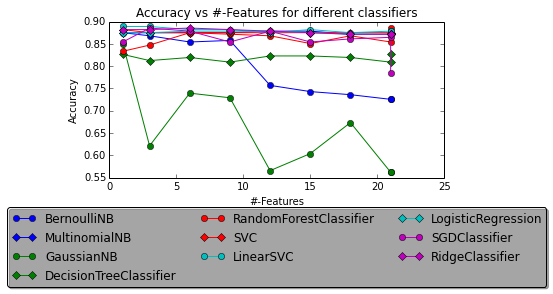

           BernoulliNB  0.726 0.726 0.736 0.750 0.830 0.872 0.868 0.875 0.875
         MultinomialNB  0.872 0.872 0.872 0.875 0.882 0.882 0.878 0.875 0.875
            GaussianNB  0.562 0.562 0.674 0.767 0.753 0.816 0.819 0.826 0.851
DecisionTreeClassifier  0.823 0.823 0.806 0.830 0.844 0.812 0.844 0.816 0.826
RandomForestClassifier  0.854 0.844 0.861 0.837 0.858 0.875 0.875 0.865 0.865
                   SVC  0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.882
             LinearSVC  0.878 0.878 0.875 0.872 0.878 0.882 0.882 0.885 0.889
    LogisticRegression  0.872 0.872 0.872 0.875 0.875 0.875 0.875 0.875 0.875
         SGDClassifier  0.774 0.833 0.858 0.858 0.872 0.861 0.854 0.840 0.858
       RidgeClassifier  0.872 0.872 0.872 0.872 0.878 0.885 0.882 0.882 0.882


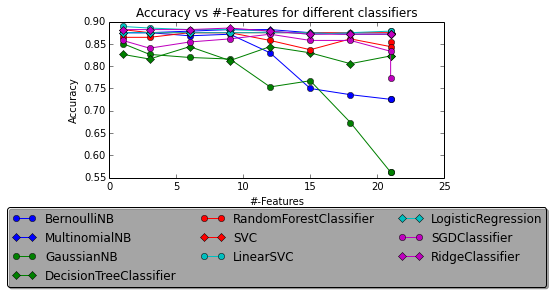

In [15]:
clfnames = map(lambda x: type(x).__name__
    if type(x).__name__ != 'OneVsRestClassifier'
    else type(x.estimator).__name__, clfs)
scoreFuncs = [chi2, f_classif]
accuracies = np.zeros((len(clfs), len(nFeatures), len(scoreFuncs)))
for k in range(0, len(scoreFuncs)):
    Xtrunc = X.copy()
    for j in range(0, len(nFeatures)):
        if nFeatures[j] != N_FEATURES:
            featureSelector = SelectKBest(score_func=scoreFuncs[k], k=nFeatures[j])
            Xtrunc = featureSelector.fit_transform(X, y)
        for i in range(0, len(clfs)):
            accuracies[i, j, k] = evaluate(Xtrunc, y, N_FOLDS, clfs[i],
                nFeatures[j], clfnames[i], scoreFuncs[k])
# print out accuracy matrix
for k in range(0, len(scoreFuncs)):
    for i in range(0, len(clfs)):
        print "%22s " % clfnames[i],
        for j in range(0, accuracies.shape[1]):
            print "%5.3f" % accuracies[i, j, k],
        print
    plot(accuracies[:, :, k], nFeatures, clfnames)            

The first part show the results and graph of accuracies for different feature sizes on different classifiers for the Chi-squared measure.
The second part is showing the same result but this time for the ANOVA F measure for feature selection.

As we can see the ANOVA F seems performing better in general for the all classifiers.

The small size of the dataset does not help us to clearly see an accuracy change as we increase or decrease the number of features but in general the accuracy is increasing as the number of feature is pruned, until a point beyond wich there are too few features for the classifier to make any reliable conclusions (bias-variance dilemma).

# Pipelining / PCA spectrum

The idea of this section is to explore the logic behind the pipline and see how this concept is useful to create combined estimator.

We are exploring the Principal Component Analysis (PCA) combined with a Logistic Regression classifier.  
PCA allow a linear dimensionality reduction using Singular Value Decomposition of the data and keeping only the most significant singular vectors to project the data to a lower dimensional space.

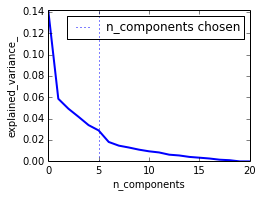

In [34]:
logistic = LogisticRegression()
pca = decomposition.PCA()
pipeline = Pipeline(steps=[
        ('reducer', pca),
        ('classifier', logistic)
    ])
pca.fit(features)

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')
n_components = [x for x in range(3, 18)]

estimator = GridSearchCV(pipeline,
                         dict(reducer__n_components=n_components))
estimator.fit(features, labels)

plt.axvline(estimator.best_estimator_.named_steps['reducer'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))


We see that the optimal `n_components` choosen for logistic regression is 5